##### Projet CO2 par Polina, Vincent, Denis

Ce notebook:
entraine un modèle de classification pour prédiction par Gradient Boosting Machines Catboost  
Prend en entrée les fichiers:
    (processed)/X_test_scaled.csv, X_train_scaled.csv, y_test_cat.csv, y_train_cat.csv : les données scalées et donc forcément préalablement séparées en jeux de train/test.

Fournit en sortie les fichiers:
    (models)/<nom_de_modele>.pkl


# Initialisations, librairies

In [ ]:
# charge les chemins vers les fichiers de données : base_processed, base_raw, base_models...
%run init_notebook.py

# Ajoute le chemin du module commun
import sys
sys.path.append('../') 

# charge nos fonctions communes aux travaux sur plusieurs modèles
from common_co2 import load_our_data_cat, display_norm_matrix, display_roc

In [ ]:
# installation des librairies lorsque nécessaire

"""!pip install seaborn """
!pip install catboost

   ---------------------------------------- 0.0/102.4 MB ? eta -:--:--
   -- ------------------------------------- 7.3/102.4 MB 42.3 MB/s eta 0:00:03
   ---- ----------------------------------- 10.5/102.4 MB 27.4 MB/s eta 0:00:04
   ------- -------------------------------- 18.9/102.4 MB 32.1 MB/s eta 0:00:03
   --------- ------------------------------ 25.2/102.4 MB 32.4 MB/s eta 0:00:03
   ----------- ---------------------------- 28.3/102.4 MB 27.7 MB/s eta 0:00:03
   -------------- ------------------------- 36.4/102.4 MB 29.1 MB/s eta 0:00:03
   ------------------ --------------------- 48.2/102.4 MB 33.2 MB/s eta 0:00:02
   ---------------------- ----------------- 58.7/102.4 MB 35.2 MB/s eta 0:00:02
   --------------------------- ------------ 70.3/102.4 MB 37.5 MB/s eta 0:00:01
   ------------------------------ --------- 77.6/102.4 MB 37.8 MB/s eta 0:00:01
   -------------------------------- ------- 83.9/102.4 MB 37.1 MB/s eta 0:00:01
   --------------------------------- ------ 87.0/1

In [3]:
from catboost import CatBoostClassifier, Pool

# Classification par Gradient Boosting Machines Catboost

In [4]:
# Optionnel: Sur windows pour utiliser 16 coeurs physiques

import os
os.environ["LOKY_MAX_CPU_COUNT"] = "16"  # nombre de cœurs physiques réels

In [5]:
# chargement des données
X_train_scaled, X_test_scaled, y_train, y_test=load_our_data_cat()

In [6]:
# On tente d'ajuster les poids des classes.
import numpy as np
from catboost import CatBoostClassifier, Pool

# Count occurrences of each class
class_counts = np.bincount(y_train)

# Calculate inverse frequency weights
total_samples = len(y_train)
class_weights = {i: total_samples / (len(class_counts) * count) for i, count in enumerate(class_counts) if count > 0}
# ceci améliore énormément le recall de la classe 2,
# mais dégrade sa precision

# force le poids de la classe 2 seulement
class_weights = {key: (1.1 if key == 2 else 1) for key in class_weights}


# Assign sample weights based on target values
sample_weights = np.array([class_weights[y] for y in y_train])
# On affiche nos poids de classes
class_weights


C:\Users\abcd3\AppData\Local\Temp\ipykernel_39208\171215039.py:6: DeprecationWarning: Non-integer input passed to bincount. In a future version of NumPy, this will be an error. (Deprecated NumPy 2.1)
  class_counts = np.bincount(y_train)


{1: 1, 2: 1.1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1}

In [7]:
# Une 1ere initialisation des hyperparamètres du modèle
hyperparams = {
    'iterations': 1000,  # Nombre d'itérations
    'learning_rate': 0.1,  # Taux d'apprentissage
    'depth': 6,  # Profondeur des arbres
    'l2_leaf_reg': 3,  # Régularisation L2
    'random_seed': 42,  # Seed pour la reproductibilité
}

In [8]:
from catboost import CatBoostClassifier, Pool

# Prepare data using `Pool`
train_pool = Pool(X_train_scaled, y_train, weight=sample_weights)
model = CatBoostClassifier(**hyperparams)

# Train model with sample weights
model.fit(train_pool, verbose=0)

In [9]:
# Fonction pour entraîner le modèle sans pondération
def train_model(model, X_train_scaled, y_train):
    """
    Entraîne le modèle.
    """
    model.fit(X_train_scaled, y_train, verbose=0)  # verbose=0 pour éviter trop de logs
    return model

# Fonction pour entraîner le modèle avec pondération
def train_model_weight(model, X_train_scaled, y_train, sample_weights):
    # Prepare data using `Pool`
    train_pool = Pool(X_train_scaled, y_train, weight=sample_weights)

    model.fit(train_pool, verbose=0)  # verbose=0 pour éviter trop de logs
    return model


# Fonction pour évaluer les performances du modèle
from sklearn.metrics import classification_report, f1_score, recall_score
def evaluate_model(model, X_test_scaled, y_test):
    """
    Calcule et affiche les métriques du modèle.
    """
    # Prédictions sur les données de test
    y_pred = model.predict(X_test_scaled)
    
    # Calcul et affichage de la précision
    accuracy = model.score(X_test_scaled, y_test)
    print(f"Précision du modèle : {accuracy:.4f}")
    
    # Calcul et affichage du F1-score
    f1 = f1_score(y_test, y_pred, average='weighted')  # 'weighted' pour les classes déséquilibrées
    print(f"F1-score : {f1:.4f}")
    
    # Calcul et affichage du recall
    recall = recall_score(y_test, y_pred, average='weighted')
    print(f"Recall : {recall:.4f}")
    
    # Affichage du rapport de classification
    report = classification_report(y_test, y_pred)
    print("Rapport de classification :")
    print(report)

    return accuracy, f1, recall, y_pred

In [10]:
# info pour les représentations graphiques
name="CatBoost"

In [11]:
#model=train_model(model, X_train_scaled, y_train)
accuracy, f1, recall, y_pred=evaluate_model(model, X_test_scaled, y_test)

Précision du modèle : 0.8845
F1-score : 0.8843
Recall : 0.8845
Rapport de classification :
              precision    recall  f1-score   support

         1.0       0.99      1.00      1.00      2887
         2.0       0.80      0.75      0.77      1441
         3.0       0.88      0.88      0.88      6138
         4.0       0.84      0.87      0.85      5435
         5.0       0.89      0.87      0.88      5061
         6.0       0.90      0.89      0.89      2610
         7.0       0.93      0.96      0.94      1163

    accuracy                           0.88     24735
   macro avg       0.89      0.89      0.89     24735
weighted avg       0.88      0.88      0.88     24735




🔹 Matrice de confusion pour CatBoost and iterations=1000, depth=6, l2_leaf_reg=3, class_weights={1: 1, 2: 1.1, 3: 1, 4: 1, 5: 1, 6: 1, 7: 1}🔹


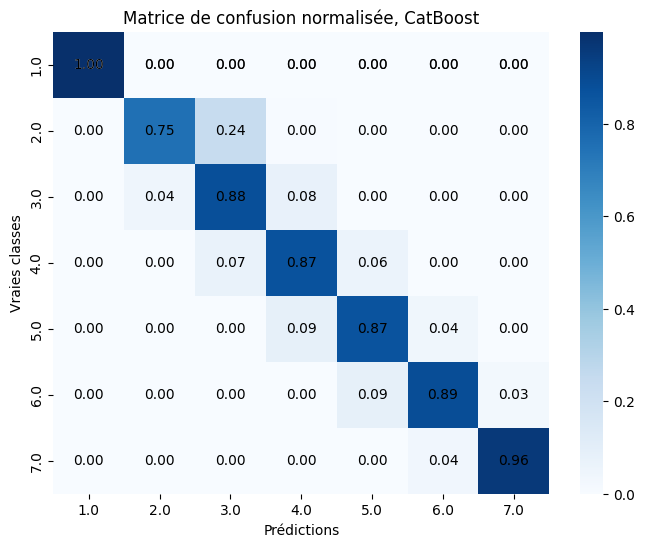

In [12]:
# On affiche notre matrice de confusion
text_hyperparams = f"iterations={hyperparams['iterations']}, depth={hyperparams['depth']}, l2_leaf_reg={hyperparams['l2_leaf_reg']}, class_weights={class_weights}"
display_norm_matrix(name, y_pred, y_test, text_hyperparams)


Quelle est la qualité du résultat ?  
Plutôt bon, mais on n'a pas encore optimisé les hyperparamètres.

In [ ]:
# Nouveau set d'hyperparamètres du modèle avec des paramètres plus ambitieux en besoins de calcul
hyperparams = {
    'iterations': 1500,  # Nombre d'itérations
    'learning_rate': 0.1,  # Taux d'apprentissage
    'depth': 6,  # Profondeur des arbres
    'l2_leaf_reg': 2,  # Régularisation L2
    'random_seed': 42,  # Seed pour la reproductibilité
}

model = CatBoostClassifier(**hyperparams)
model=train_model(model, X_train_scaled, y_train)
accuracy, f1, recall, y_pred=evaluate_model(model, X_test_scaled, y_test)

Précision du modèle : 0.8894
F1-score : 0.8893
Recall : 0.8894
Rapport de classification :
              precision    recall  f1-score   support

         1.0       0.99      1.00      1.00      2887
         2.0       0.80      0.75      0.78      1441
         3.0       0.88      0.89      0.88      6138
         4.0       0.85      0.87      0.86      5435
         5.0       0.89      0.87      0.88      5061
         6.0       0.91      0.89      0.90      2610
         7.0       0.93      0.96      0.95      1163

    accuracy                           0.89     24735
   macro avg       0.89      0.89      0.89     24735
weighted avg       0.89      0.89      0.89     24735



# Optimisation par pondération

In [ ]:
# On tente d'ajuster les poids des classes.
import numpy as np
from catboost import CatBoostClassifier, Pool

# Count occurrences of each class
class_counts = np.bincount(y_train)

# Calculate inverse frequency weights
total_samples = len(y_train)
class_weights = {i: total_samples / (len(class_counts) * count) for i, count in enumerate(class_counts) if count > 0}
# ceci améliore énormément le recall de la classe 2,
# mais dégrade sa precision

# force le poids de la classe 2 seulement
class_weights = {key: (1.1 if key == 2 else 1) for key in class_weights}


# Assign sample weights based on target values
sample_weights = np.array([class_weights[y] for y in y_train])
# On affiche nos poids de classes
class_weights


In [ ]:
# init et entraînement du modèle avec les poids de classes

model = CatBoostClassifier(**hyperparams)
model=train_model_weight(model, X_train_scaled, y_train, sample_weights)

In [ ]:
# on affiche l'évaluation des performances 
accuracy, f1, recall, y_pred=evaluate_model(model, X_test_scaled, y_test)

Précision du modèle : 0.8905
F1-score : 0.8904
Recall : 0.8905
Rapport de classification :
              precision    recall  f1-score   support

         1.0       0.99      1.00      1.00      2887
         2.0       0.79      0.77      0.78      1441
         3.0       0.88      0.88      0.88      6138
         4.0       0.85      0.87      0.86      5435
         5.0       0.90      0.87      0.88      5061
         6.0       0.91      0.89      0.90      2610
         7.0       0.93      0.96      0.95      1163

    accuracy                           0.89     24735
   macro avg       0.89      0.89      0.89     24735
weighted avg       0.89      0.89      0.89     24735




🔹 Matrice de confusion pour CatBoost and iterations=1500, depth=6, l2_leaf_reg=2, weights🔹


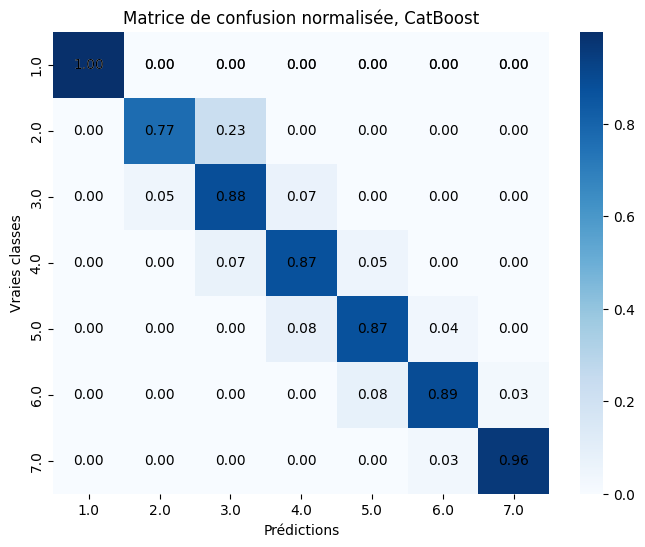

In [ ]:
# on affiche la matrice de confusion
text_hyperparams = f"iterations={hyperparams['iterations']}, depth={hyperparams['depth']}, l2_leaf_reg={hyperparams['l2_leaf_reg']}, weights"
display_norm_matrix(name, y_pred, y_test, text_hyperparams)

# Tentative d'amélioration par SMOTE

In [ ]:
# Notre set d'hyperparamètres du modèle
hyperparams = {
    'iterations': 1500,  # Nombre d'itérations
    'learning_rate': 0.1,  # Taux d'apprentissage
    'depth': 6,  # Profondeur des arbres
    'l2_leaf_reg': 2,  # Régularisation L2
    'random_seed': 42,  # Seed pour la reproductibilité
}

from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_scaled, y_train)


model = CatBoostClassifier(**hyperparams)
model=train_model(model, X_train_resampled, y_train_resampled)
accuracy, f1, recall, y_pred=evaluate_model(model, X_test_scaled, y_test)


In [ ]:
text_hyperparams = f"iterations={hyperparams['iterations']}, depth={hyperparams['depth']}, l2_leaf_reg={hyperparams['l2_leaf_reg']}"
text_hyperparams += f", SMOTE"
display_norm_matrix(name, y_pred, y_test, text_hyperparams)
# display_confusion_matrix(model, X_test_scaled, y_test, name=name, params=hyperparams)

In [ ]:
display_roc(X_test_scaled, y_test, y_pred, model)

On ne constate pas d'amélioration significative de la précision du modèle, même si le recall est meilleur sur la classe 2.

# Tentative d'amélioration par pénalité

La classe 2 est sous représentée par rapport à la classe 3,  
on applique donc une pénalité aux probabilités

In [ ]:
# paramètres pour ce chapitre:
threshold = 0.05 # par exemple 0.1 pour 10% de favorisation

In [ ]:
# Prédire les classes sur les données de test
import numpy as np
y_prob = model.predict_proba(X_test_scaled)

y_adjusted_pred = []

# Custom logic: on priorisera class 2 si c'est celle qui est la plus probable au threshold près
for prob in y_prob:
    # La classe avec la plus haute probe est:
    max_prob_class_index = np.argmax(prob)

    # Check if class 2 is close enough to the maximum probability
    if prob[1] >= prob[max_prob_class_index] - threshold:  # Close enough to the max probability
        y_adjusted_pred.append(2)  # Favor class 2
    else:
        y_adjusted_pred.append(max_prob_class_index+1)  # Stick to the class with the highest probability


In [ ]:
# Pour info , on s'affiche les probabilités
display(y_prob)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, recall_score

# On va calculer et afficher les métriques de performance
adjusted_accuracy = accuracy_score(y_test, y_adjusted_pred)
adjusted_f1 = f1_score(y_test, y_adjusted_pred, average='weighted')
adjusted_recall = recall_score(y_test, y_adjusted_pred, average='weighted')  # Include recall calculation

print(f"Accuracy ajustée par pénalité : {adjusted_accuracy:.4f}")
print(f"F1-Score ajusté par pénalité: {adjusted_f1:.4f}")
print(f"Recall ajustée par pénalité: {adjusted_recall:.4f}")


Les résultats s'améliorent avec des pénalités de 2.5% à 7%
Avec une pénalité de 5%, on a pu améliorer les scores de 0.001 point. C'est peu, mais dans la recherche de la maximisation, ça peut être retenu.


In [ ]:
# pour info, les lignes qui ont bougé avec la pénalisation

# Convert y_pred to a 1D array for easier comparison
y_pred_1d = np.array(y_pred).flatten()

# Ensure y_adjusted_pred is a numpy array for consistency
y_adjusted_pred_array = np.array(y_adjusted_pred)

y_test_array=np.array(y_test)

# Compare the two arrays element-wise
differences = y_pred_1d != y_adjusted_pred_array

# Print comparison results
for i, (pred, adjusted, tst) in enumerate(zip(y_pred_1d, y_adjusted_pred_array, y_test_array)):
    if pred != adjusted:
        print(f"Difference at index {i}: y_pred = {pred}, y_adjusted_pred = {adjusted}, real={tst}")

In [ ]:
# affichage de la matrice
text_hyperparams = f"iterations={hyperparams['iterations']}, depth={hyperparams['depth']}, l2_leaf_reg={hyperparams['l2_leaf_reg']}"
text_hyperparams += f", pénalité {threshold*100} %"
display_norm_matrix(name, y_adjusted_pred, y_test, text_hyperparams)

# Sauvegarde du modèle

In [ ]:
import joblib

# Chemin pour enregistrer le modèle
model_path = base_models + 'rf_cat.pkl'

# Enregistrer le modèle
joblib.dump(random_forest_model, model_path)

print(f"Modèle Catboost enregistré dans {model_path}")
